# Knn Regression

1. Choose K (the number of clusters you want).

2. Initialize K centroids randomly.

3. Repeat until convergence:
   a. Assign each data point to the nearest centroid.
   b. Recalculate the centroids based on the current assignment of data points.
   
4. Return the final K centroids and the corresponding cluster assignments.


### Import Modules and Read Dataset

In [955]:
# import modules 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline 

In [956]:
df = pd.read_csv('../cleaning-preprocessing/cleaned_flight_data_with_target.csv')
# df.head(5)

In [957]:
df = df.astype(int)
# df.head(5)

In [958]:
# Spliting the dataset
# Getting DEP_DELAY for the once only delay 
# any positive values means that it is early departure

df = df[df['DEP_DELAY'] > 0]
df

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,CRS_ARR_M,Temperature,Dew Point,Humidity,...,Condition_Light Snow / Windy,Condition_Mostly Cloudy,Condition_Mostly Cloudy / Windy,Condition_Partly Cloudy,Condition_Partly Cloudy / Windy,Condition_Rain,Condition_Rain / Windy,Condition_Snow,Condition_Wintry Mix,Condition_Wintry Mix / Windy
2,11,1,5,181,1069,301,482,48,34,58,...,0,0,0,0,0,0,0,0,0,0
9,11,1,5,184,1069,370,554,46,32,58,...,0,0,0,0,0,0,0,0,0,0
14,11,1,5,222,1598,301,523,46,32,58,...,0,0,0,0,0,0,0,0,0,0
26,11,1,5,184,1089,420,604,47,33,59,...,0,0,0,0,0,0,0,0,0,0
30,11,1,5,75,266,455,530,47,33,59,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28811,1,31,5,406,2586,1273,59,40,38,93,...,0,0,0,0,0,0,0,0,0,0
28815,1,31,5,57,150,1370,1427,39,38,96,...,0,0,0,0,0,0,0,0,0,0
28816,1,31,5,75,187,1390,25,39,38,96,...,0,0,0,0,0,0,0,0,0,0
28817,1,31,5,392,2422,1125,1337,39,38,96,...,0,0,0,0,0,0,0,0,0,0


### Transformation Testing

DEP_DELAY skew score
6.747267428396521
DEP_DELAY_log skew score
0.18656313676157155
DEP_DELAY_BOXCOX skew score
0.019062682996326904


/Users/engineererjojo/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/engineererjojo/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/engineererjojo/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


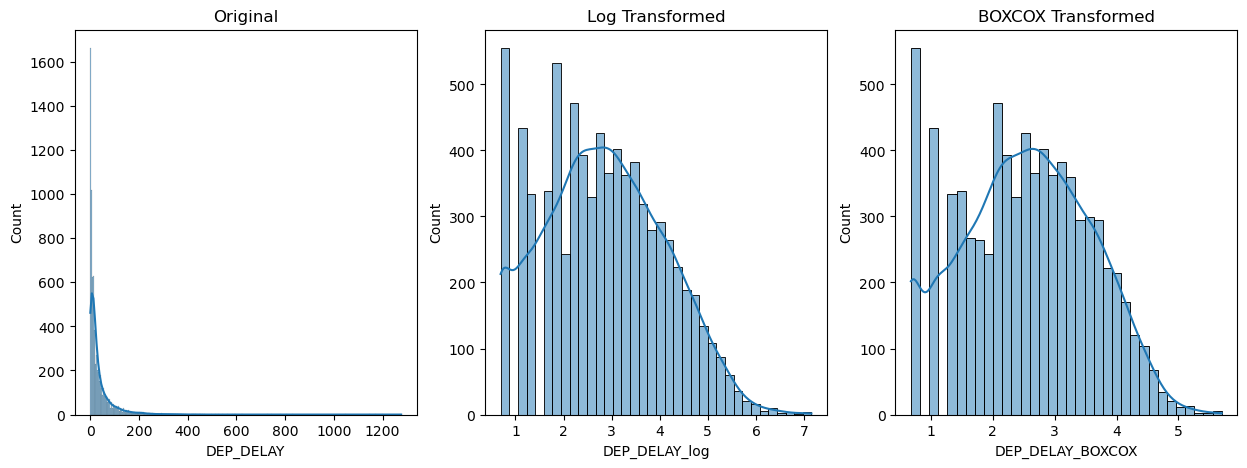

In [959]:
print('DEP_DELAY skew score')
print(df['DEP_DELAY'].skew())  # If > 0.5 or < -0.5, transformation is needed

df['DEP_DELAY_shifted'] = df['DEP_DELAY'] - df['DEP_DELAY'].min() + 1
# df['DEP_DELAY_log'] = np.log1p(df['DEP_DELAY_shifted'])

df['DEP_DELAY_log'] = np.log1p(df['DEP_DELAY_shifted'])  # log1p avoids log(0) issue
df['DEP_DELAY_sqrt'] = np.sqrt(df['DEP_DELAY_shifted']) # sqrt version

from scipy.stats import boxcox
df['DEP_DELAY_BOXCOX'], lambda_ = boxcox(df['DEP_DELAY_shifted'] + 1)  # Adding 1 to avoid issues with 0
# print(f' lambda value {lambda_}')

print('DEP_DELAY_log skew score')
print(df['DEP_DELAY_log'].skew())

print('DEP_DELAY_BOXCOX skew score')
print(df['DEP_DELAY_BOXCOX'].skew())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(df['DEP_DELAY'], kde=True, ax=axes[0])
axes[0].set_title('Original')

sns.histplot(df['DEP_DELAY_log'], kde=True, ax=axes[1])
axes[1].set_title('Log Transformed')

sns.histplot(df['DEP_DELAY_BOXCOX'], kde=True, ax=axes[2])
axes[2].set_title('BOXCOX Transformed')

plt.show()

In [960]:
df['DEP_DELAY_BOXCOX']

2        3.293189
9        1.324719
14       4.034096
26       1.526844
30       1.826046
           ...   
28811    3.766394
28815    1.059699
28816    1.059699
28817    4.714799
28818    1.689795
Name: DEP_DELAY_BOXCOX, Length: 7805, dtype: float64

In [961]:
X = df.drop(columns=['DEP_DELAY_log', 'DEP_DELAY','DEP_DELAY_shifted', 'DEP_DELAY_sqrt', 'DEP_DELAY_BOXCOX']) #Dropping Transformation comparsion testing columns

# Using BoxCox Transformation
y = df['DEP_DELAY_BOXCOX'] # Target variable

y.head(3)

2     3.293189
9     1.324719
14    4.034096
Name: DEP_DELAY_BOXCOX, dtype: float64

### Feature Selection (Post Boxcox Transformation)

In [962]:
X = X.applymap(lambda x: max(x, 0))
X = X.fillna(X.mean())

/var/folders/06/6rnd9mvj2tg64m2vg9cssn0w0000gn/T/ipykernel_19069/3256436071.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: max(x, 0))


In [963]:
k_num_features = 10

# Using 9 features only taking all F-Score above 60

In [964]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SelectKBest with f_regression
k = k_num_features  # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Create a DataFrame with feature names and scores
feature_df_before = pd.DataFrame({'Feature': selected_features, 'F-Score': feature_scores})
feature_df_before = feature_df_before.sort_values(by='F-Score', ascending=False)

# Print the selected features
print("Selected Features:")
print(feature_df_before)

Selected Features:
                    Feature     F-Score
5                   sch_dep  212.317215
1                  DISTANCE  122.432884
0          CRS_ELAPSED_TIME  122.028718
7      OP_UNIQUE_CARRIER_DL  105.943508
3                Wind Speed   68.595750
2                 CRS_DEP_M   67.671989
4                  Pressure   67.200056
8      OP_UNIQUE_CARRIER_MQ   46.249099
6      OP_UNIQUE_CARRIER_B6   38.740548
9  Condition_Cloudy / Windy   32.983399


### BoxCox TransFormation

In [965]:
from scipy.stats import boxcox
X['sch_dep_boxcox'], lambda_ = boxcox(X['sch_dep'] + 1)  #Top1 Feature 
X['CRS_DEP_M_boxcox'], lambda_ = boxcox(X['CRS_DEP_M'] + 1) #Top2 Feature
X['OP_UNIQUE_CARRIER_DL_boxcox'], lambda_ = boxcox(X['OP_UNIQUE_CARRIER_DL'] + 1)  #Top3 Feature

X['CRS_ELAPSED_TIME_boxcox'], lambda_ = boxcox(X['CRS_ELAPSED_TIME'] + 1)  #Top4 Feature
X['DISTANCE_boxcox'], lambda_ = boxcox(X['DISTANCE'] + 1)  #Top5 Feature
X['OP_UNIQUE_CARRIER_B6_boxcox'], lambda_ = boxcox(X['OP_UNIQUE_CARRIER_B6'] + 1)  #Top6  Feature

X['OP_UNIQUE_CARRIER_MQ_boxcox'], lambda_ = boxcox(X['OP_UNIQUE_CARRIER_MQ'] + 1)  #Top7  Feature
X['Wind_Speed_boxcox'], lambda_ = boxcox(X['Wind Speed'] + 1) #Top8  Feature
X['Pressure_boxcox'], lambda_ = boxcox(X['Pressure'] + 1) #Top9  Feature



/var/folders/06/6rnd9mvj2tg64m2vg9cssn0w0000gn/T/ipykernel_19069/42130793.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X['sch_dep_boxcox'], lambda_ = boxcox(X['sch_dep'] + 1)  #Top1 Feature
/var/folders/06/6rnd9mvj2tg64m2vg9cssn0w0000gn/T/ipykernel_19069/42130793.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X['CRS_DEP_M_boxcox'], lambda_ = boxcox(X['CRS_DEP_M'] + 1) #Top2 Feature
/var/folders/06/6rnd9mvj2tg64m2vg9cssn0w0000gn/T/ipykernel_19069/42130793.py:4: PerformanceWarning: DataFrame is highly fragmented.  This

In [966]:
# Drop columns that are log transform
X = X.drop(columns=[
            # 'sch_dep',
            # 'CRS_DEP_M',
            # 'OP_UNIQUE_CARRIER_DL',  
            # 'CRS_ELAPSED_TIME', 
            # 'DISTANCE',  
            # 'OP_UNIQUE_CARRIER_B6', 
            # 'OP_UNIQUE_CARRIER_MQ', 
            # 'Wind Speed',  
            # 'Pressure',
])

X = X.drop(columns=[
            'sch_dep_boxcox',
            'CRS_DEP_M_boxcox',
            'OP_UNIQUE_CARRIER_DL_boxcox',  
            'CRS_ELAPSED_TIME_boxcox', 
            'DISTANCE_boxcox',  
            'OP_UNIQUE_CARRIER_B6_boxcox', 
            'OP_UNIQUE_CARRIER_MQ_boxcox', 
            'Wind_Speed_boxcox',  
            'Pressure_boxcox',
])

### Comparsing F-Score of Boxcox-Feature 
Check Feature Selection F-Score Again

In [967]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SelectKBest with f_regression
k = k_num_features - 1 # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Create a DataFrame with feature names and scores
feature_df = pd.DataFrame({'Feature': selected_features, 'F-Score': feature_scores})
feature_df = feature_df.sort_values(by='F-Score', ascending=False)

# Print the selected features
print("Selected Features (New Comparsion):")
print(feature_df)

Selected Features (New Comparsion):
                Feature     F-Score
5               sch_dep  212.317215
1              DISTANCE  122.432884
0      CRS_ELAPSED_TIME  122.028718
7  OP_UNIQUE_CARRIER_DL  105.943508
3            Wind Speed   68.595750
2             CRS_DEP_M   67.671989
4              Pressure   67.200056
8  OP_UNIQUE_CARRIER_MQ   46.249099
6  OP_UNIQUE_CARRIER_B6   38.740548


### Split Training and Test Data 80:20

In [968]:
from sklearn.model_selection import train_test_split 
# X needs to be updated 

X_train, X_test, y_train, y_test = train_test_split(X[feature_df['Feature']], y, test_size = 0.2, random_state = 27)

In [969]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Diff Regression

In [970]:
# from sklearn.linear_model import LinearRegression
# regressor = LinearRegression()
# regressor.fit(X_train, y_train)

# from sklearn.tree import DecisionTreeRegressor
# regressor = DecisionTreeRegressor(random_state = 0)
# regressor.fit(X_train, y_train)

# from sklearn.ensemble import RandomForestRegressor
# regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
# regressor.fit(X_train, y_train)

# from sklearn.svm import SVR
# regressor = SVR(kernel = 'rbf')
# regressor.fit(X_train, y_train)

### KNN Model

In [971]:
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=15, metric='manhattan', weights='distance')
# regressor = KNeighborsRegressor(n_neighbors=19, metric='euclidean')

regressor.fit(X_train, y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=15, weights='distance')

### Training Set Graph (TESTING)

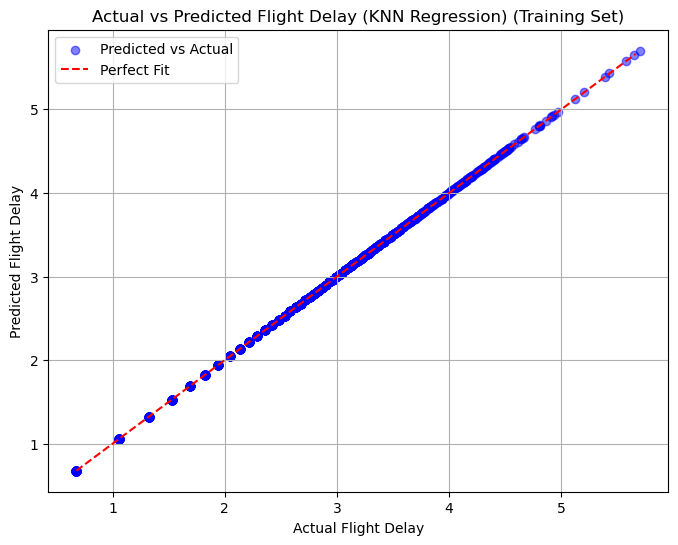

In [972]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label="Perfect Fit")

plt.xlabel("Actual Flight Delay")
plt.ylabel("Predicted Flight Delay")
plt.title("Actual vs Predicted Flight Delay (KNN Regression) (Training Set)")
plt.legend()
plt.grid(True)
plt.show()

### Results (MSE, MAE,  Predic vs Acutal Graph)

In [973]:
y_pred_boxcox = regressor.predict(X_test)

# Reverse Box-Cox Transformation
print(lambda_)

if lambda_ == 0:
    y_pred = np.exp(y_pred_boxcox)  # If λ = 0, use exp()
else:
    y_pred = (y_pred_boxcox * lambda_ + 1) ** (1 / lambda_)  # General inverse Box-Cox formula


42.61050302458439


In [974]:
y_pred

array([1.11533857, 1.11826981, 1.10893234, ..., 1.11233233, 1.11973196,
       1.10970961])

In [975]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print("\nModel Performance Metrics:")
# print(f"Mean Squared Error (MSE): {mse:.2f}")
# print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"R-Squared (R2): {r2:.4f}")

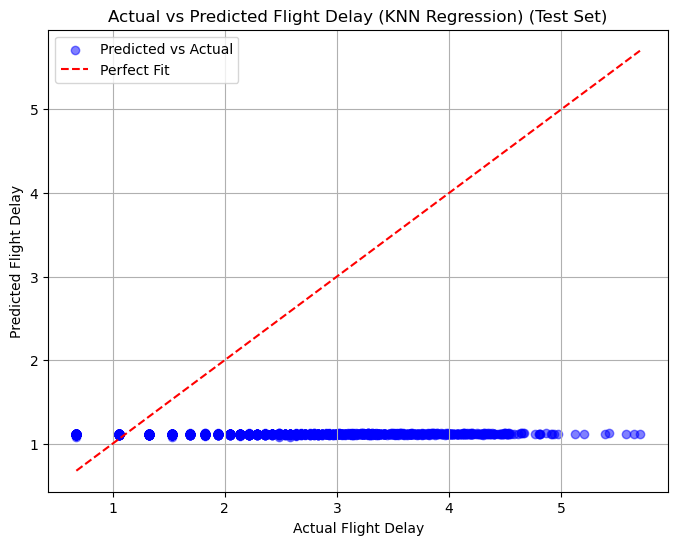

In [976]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")

plt.xlabel("Actual Flight Delay")
plt.ylabel("Predicted Flight Delay")
plt.title("Actual vs Predicted Flight Delay (KNN Regression) (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

In [977]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'n_neighbors': range(3, 11, 2)}
# grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
# grid.fit(X_train, y_train)
# print("Best k:", grid.best_params_)